<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment9/Assignment_9_AutoEncoders_Srinath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

# import statements

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

from matplotlib import pyplot as plt

# Change the directory

In [ ]:
working_directory = '/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/09_Assignment'
def colabDrive():
    from google.colab import drive
    drive.mount("/content/drive")

    if os.getcwd() !=  working_directory:
      os.chdir(working_directory)
    print(os.getcwd())

In [ ]:
colabDrive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/08a_Assignment


# Load the dataset

## Original Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = (x_train.astype('float32') / 255)
x_test = (x_test.astype('float32') / 255)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(x_train.shape[0]).batch(512)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(100)

# pick a random subset
labeled_indices = np.random.choice(60000, replace=False, size=1000)

print("Original Dataset Size")
print ("Train Dataset Size: ", x_train.shape)
print ("Test Dataset Size: ", x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
Original Dataset Size
Train Dataset Size:  (60000, 28, 28)
Test Dataset Size:  (10000, 28, 28)


## AutoEncoder1 Dataset

In [3]:
auto_train_data = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(x_train.shape[0]).batch(512)
auto_test_data = tf.data.Dataset.from_tensor_slices((x_test, x_test)).batch(100)

# choose corresponding images and labels
x_train_subset = x_train[labeled_indices]
y_train_subset = y_train[labeled_indices]

train_subset_data = tf.data.Dataset.from_tensor_slices((x_train_subset, y_train_subset)).shuffle(x_train_subset.shape[0]).batch(100)

print("Subset Dataset Size")
print ("Train Subset Dataset Size: ", x_train_subset.shape)

Subset Dataset Size
Train Subset Dataset Size:  (1000, 28, 28)


## AutoEncoder2 Denoise Dataset

In [4]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

train_noisy_data = tf.data.Dataset.from_tensor_slices((x_train_noisy, y_train)).shuffle(x_train.shape[0]).batch(512)
test_noisy_data = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test)).batch(100)

auto2_train_data = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train)).shuffle(x_train.shape[0]).batch(512)
auto2_test_data = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test)).batch(100)

x_train_noisy_subset = []
# choose corresponding images and labels
for index in labeled_indices:
    x_train_noisy_subset.append(x_train_noisy[index])
x_train_noisy_subset = np.array(x_train_noisy_subset)
y_train_subset = y_train[labeled_indices]

train_noisy_subset_data = tf.data.Dataset.from_tensor_slices((x_train_noisy_subset, y_train_subset)).shuffle(x_train_noisy_subset.shape[0]).batch(100)

print("Noisy Subset Dataset Size")
print ("Train Subset Dataset Size: ", x_train_noisy_subset.shape)

Noisy Subset Dataset Size
Train Subset Dataset Size:  (1000, 28, 28)


# Model1

## Definition

In [5]:
bottleNeck = 64
input_shape = (28, 28)

#Encoder
image_input = tf.keras.Input(input_shape)  # flattened 28x28 MNIST images
flatten = tf.keras.layers.Flatten()(image_input)
enc_Layer1 = tf.keras.layers.Dense(256)(flatten)
enc_Layer2 = tf.keras.layers.Dense(128)(enc_Layer1)
encoding = tf.keras.layers.Dense(bottleNeck)(enc_Layer2)
encoder = tf.keras.Model(image_input, encoding, name="Encoder")

#Decoder
code_input = tf.keras.Input((bottleNeck,))
dec_Layer1 = tf.keras.layers.Dense(128)(code_input)
dec_Layer2 = tf.keras.layers.Dense(256)(dec_Layer1)
decoding = tf.keras.layers.Dense(784, tf.nn.sigmoid)(dec_Layer2)
decoding2 = tf.keras.layers.Reshape(input_shape)(decoding)
decoder = tf.keras.Model(code_input, decoding2, name="Decoder")

#Auto-Encoder
autoencoder = tf.keras.Model(image_input, decoder(encoder(image_input)), name="AutoEncoder")

# Extended Model Head for Classification
layer1 =  tf.keras.layers.Dense(512)(encoding)
layer2 =  tf.keras.layers.Dense(256)(layer1)

logits = tf.keras.layers.Dense(10)(layer2)

classifier = tf.keras.Model(image_input, logits, name="Classifer")


#Classifier 2
c2_flatten = tf.keras.layers.Flatten()(image_input)
c2_layer1 = tf.keras.layers.Dense(256)(c2_flatten)
c2_layer2 = tf.keras.layers.Dense(128)(c2_layer1)
c2_layer3 = tf.keras.layers.Dense(bottleNeck)(c2_layer2)
c2_layer4 =  tf.keras.layers.Dense(512)(c2_layer3)
c2_layer5 =  tf.keras.layers.Dense(256)(c2_layer4)
c2_logits = tf.keras.layers.Dense(10)(layer2)
classifier2 = tf.keras.Model(image_input, c2_logits, name="Classifer2")


## Model Summary

In [6]:
encoder.summary()
decoder.summary()
autoencoder.summary()
classifier.summary()
classifier2.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
Total params: 242,112
Trainable params: 242,112
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
____________________________________

## Model Training

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [8]:
autoencoder.fit(auto_train_data,
                epochs=10)

Epoch 1/10
118/118 [==============================] - 3s 5ms/step - loss: 0.0459
Epoch 2/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0197
Epoch 3/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0162
Epoch 4/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0142
Epoch 5/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0130
Epoch 6/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0122
Epoch 7/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0116
Epoch 8/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0111
Epoch 9/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0108
Epoch 10/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0104


## Model Testing

In [9]:
autoencoder.evaluate(auto_test_data)

100/100 [==============================] - 0s 2ms/step - loss: 0.0104


0.01038777269423008

In [10]:
encoded_imgs = encoder(x_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

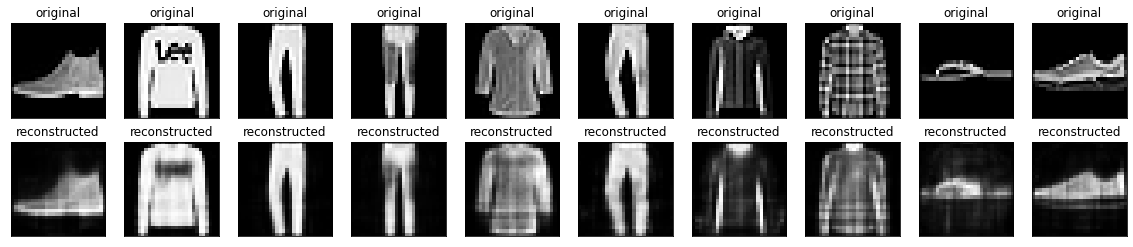

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Transfer Learning on 1000 samples

In [12]:
encoder.trainable = False  # Freeze the encoder!
print("ENCODER")  # no more trainable variables
print(encoder.trainable_variables)

ENCODER
[]


In [13]:
classifier.compile( optimizer=tf.optimizers.Adam(), 
                    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics   = tf.metrics.SparseCategoricalAccuracy(),)

In [14]:
classifier.summary()

Model: "Classifer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 512)               33280     
                                                                 
 dense_7 (Dense)             (None, 256)               13

In [15]:
classifier.fit(train_subset_data,
               epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.5900
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6965 - sparse_categorical_accuracy: 0.7760
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6054 - sparse_categorical_accuracy: 0.7780
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4862 - sparse_categorical_accuracy: 0.8200
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4596 - sparse_categorical_accuracy: 0.8350
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4400 - sparse_categorical_accuracy: 0.8440
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4223 - sparse_categorical_accuracy: 0.8460
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4275 - sparse_categorical_accuracy: 0.8400
Epoch 9/10
10/10 [==============================] - 0s 2ms/step 

### Test Accuracy

In [16]:
classifier.evaluate(test_data)

100/100 [==============================] - 0s 2ms/step - loss: 0.7490 - sparse_categorical_accuracy: 0.7615


[0.7489743828773499, 0.7615000009536743]

## Classifier 2

In [17]:
classifier2.compile( optimizer=tf.optimizers.Adam(), 
                    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics   = tf.metrics.SparseCategoricalAccuracy(),)

In [18]:
classifier2.fit(train_data,
               epochs=10)

Epoch 1/10
118/118 [==============================] - 1s 4ms/step - loss: 0.5853 - sparse_categorical_accuracy: 0.7969
Epoch 2/10
118/118 [==============================] - 0s 3ms/step - loss: 0.5076 - sparse_categorical_accuracy: 0.8211
Epoch 3/10
118/118 [==============================] - 0s 4ms/step - loss: 0.5043 - sparse_categorical_accuracy: 0.8221
Epoch 4/10
118/118 [==============================] - 0s 4ms/step - loss: 0.4962 - sparse_categorical_accuracy: 0.8257
Epoch 5/10
118/118 [==============================] - 0s 4ms/step - loss: 0.4943 - sparse_categorical_accuracy: 0.8260
Epoch 6/10
118/118 [==============================] - 0s 4ms/step - loss: 0.4886 - sparse_categorical_accuracy: 0.8279
Epoch 7/10
118/118 [==============================] - 0s 4ms/step - loss: 0.4886 - sparse_categorical_accuracy: 0.8283
Epoch 8/10
118/118 [==============================] - 0s 4ms/step - loss: 0.4871 - sparse_categorical_accuracy: 0.8280
Epoch 9/10
118/118 [============================

In [19]:
classifier2.evaluate(test_data)

100/100 [==============================] - 0s 2ms/step - loss: 0.5072 - sparse_categorical_accuracy: 0.8174


[0.5071781873703003, 0.8173999786376953]

# Model2

## Definition

In [20]:
bottleNeck = (4, 4, 16)
input_shape = (28, 28, 1)

#Encoder
image_input = tf.keras.Input(input_shape)
m2_enc_Layer1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding='same', strides=2)(image_input)
m2_encoding = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding='same', strides=2)(m2_enc_Layer1)
m2_encoder = tf.keras.Model(image_input, m2_encoding, name="Encoder2")

#Decoder
m2_dec_Layer1 = tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(m2_encoding)
m2_dec_Layer2 = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(m2_dec_Layer1)
m2_decoding = layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(m2_dec_Layer2)
m2_decoder = tf.keras.Model(m2_encoding, m2_decoding, name="Decoder2")

#Auto-Encoder
m2_autoencoder = tf.keras.Model(image_input, m2_decoder(m2_encoder(image_input)), name="AutoEncoder2")

# Extended Model Head for Classification
m2_flatten = tf.keras.layers.Flatten()(m2_encoding)
m2_layer1 =  tf.keras.layers.Dense(512)(m2_flatten)
m2_layer2 =  tf.keras.layers.Dense(256)(m2_layer1)

m2_logits = tf.keras.layers.Dense(10)(m2_layer2)

m2_classifier = tf.keras.Model(image_input, m2_logits, name="ClassiferV21")


#Classifier 2
m2_c2_inp = tf.keras.Input(input_shape)
m2_c2_layer1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding='same', strides=2)(m2_c2_inp)
m2_c2_layer2 = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding='same', strides=2)(m2_c2_layer1)
m2_c2_flatten = tf.keras.layers.Flatten()(m2_c2_layer2)
m2_c2_layer4 =  tf.keras.layers.Dense(512)(m2_c2_flatten)
m2_c2_layer5 =  tf.keras.layers.Dense(256)(m2_c2_layer4)
m2_c2_logits = tf.keras.layers.Dense(10)(m2_layer2)
m2_classifier2 = tf.keras.Model(image_input, m2_c2_logits, name="ClassiferV22")


## Model Summary

In [21]:
m2_encoder.summary()
m2_decoder.summary()
m2_autoencoder.summary()
m2_classifier.summary()
m2_classifier2.summary()

Model: "Encoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 8)]         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 1

## Model Training

In [22]:
m2_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [23]:
m2_autoencoder.fit(auto2_train_data,
                epochs=10)

Epoch 1/10
118/118 [==============================] - 9s 13ms/step - loss: 0.0962
Epoch 2/10
118/118 [==============================] - 2s 13ms/step - loss: 0.0268
Epoch 3/10
118/118 [==============================] - 2s 12ms/step - loss: 0.0156
Epoch 4/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0136
Epoch 5/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0126
Epoch 6/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0119
Epoch 7/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0114
Epoch 8/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0109
Epoch 9/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0105
Epoch 10/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0103


## Model Testing

In [24]:
m2_autoencoder.evaluate(auto2_test_data)

100/100 [==============================] - 0s 3ms/step - loss: 0.0103


0.010326802730560303

In [25]:
m2_encoded_imgs = m2_encoder(x_test_noisy).numpy()
m2_decoded_imgs = m2_decoder(m2_encoded_imgs).numpy()

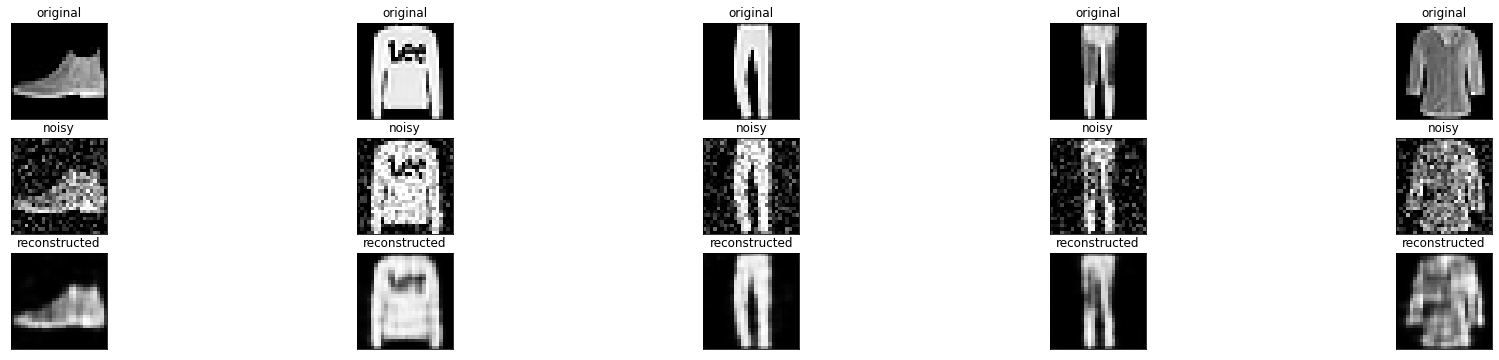

In [39]:
n = 5
plt.figure(figsize=(30, 6))
for i in range(n):
  # display original
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display noisy
  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(x_test_noisy[i])
  plt.title("noisy")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, i + 1 + n + n)
  m2_dec = np.squeeze(m2_decoded_imgs[i], axis=-1)
  plt.imshow(m2_dec)
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Transfer Learning on 1000 samples

In [40]:
m2_encoder.trainable = False  # Freeze the encoder!
print("ENCODER")  # no more trainable variables
print(m2_encoder.trainable_variables)

ENCODER
[]


In [41]:
m2_classifier.compile( optimizer=tf.optimizers.Adam(), 
                    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics   = tf.metrics.SparseCategoricalAccuracy(),)

In [42]:
m2_classifier.summary()

Model: "ClassiferV21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 flatten_2 (Flatten)         (None, 392)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               201216    
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 10)               

In [43]:
m2_classifier.fit(train_noisy_subset_data,
               epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 3ms/step - loss: 3.5170 - sparse_categorical_accuracy: 0.2990
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.2072 - sparse_categorical_accuracy: 0.5330
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9837 - sparse_categorical_accuracy: 0.6390
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.7435 - sparse_categorical_accuracy: 0.7080
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6729 - sparse_categorical_accuracy: 0.7490
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6245 - sparse_categorical_accuracy: 0.7680
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5718 - sparse_categorical_accuracy: 0.7870
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4949 - sparse_categorical_accuracy: 0.8090
Epoch 9/10
10/10 [==============================] - 0s 3ms/step 

### Test Accuracy

In [44]:
m2_classifier.evaluate(test_data)

100/100 [==============================] - 0s 2ms/step - loss: 0.7022 - sparse_categorical_accuracy: 0.7565


[0.7022375464439392, 0.7565000057220459]

## Classifier 2

In [45]:
m2_classifier2.compile( optimizer=tf.optimizers.Adam(), 
                    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics   = tf.metrics.SparseCategoricalAccuracy(),)

In [46]:
m2_classifier2.fit(train_noisy_data,
               epochs=10)

Epoch 1/10
118/118 [==============================] - 1s 4ms/step - loss: 0.6923 - sparse_categorical_accuracy: 0.7509
Epoch 2/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4997 - sparse_categorical_accuracy: 0.8170
Epoch 3/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4798 - sparse_categorical_accuracy: 0.8244
Epoch 4/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4671 - sparse_categorical_accuracy: 0.8289
Epoch 5/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4654 - sparse_categorical_accuracy: 0.8312
Epoch 6/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4601 - sparse_categorical_accuracy: 0.8323
Epoch 7/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4488 - sparse_categorical_accuracy: 0.8368
Epoch 8/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4504 - sparse_categorical_accuracy: 0.8371
Epoch 9/10
118/118 [============================

In [48]:
m2_classifier2.evaluate(test_data)

100/100 [==============================] - 0s 3ms/step - loss: 0.4874 - sparse_categorical_accuracy: 0.8291


[0.48741427063941956, 0.8291000127792358]

# References



1.   https://ovgu-ailab.github.io/idl2021/ass9.html
2.   https://www.tensorflow.org/tutorials/generative/autoencoder#second_example_image_denoising

